<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Project/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Nikita Oltyan Project

In [ ]:
from collections import namedtuple

import os
import matplotlib.pyplot as plt
import numpy as np
import sys
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

## 1 Downloading data from Drive 
All data was prepared in separate notebook "Data_Preparing.ipynb" and then uploaded on the Google Drive.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1es2oZELrD1b4DW3RfdM62iHnUVXlx-5I"})   
downloaded.GetContentFile('skyline_data.zip')

In [ ]:
! unzip skyline_data.zip

Archive:  skyline_data.zip
   creating: skyline_data/
  inflating: skyline_data/.DS_Store  
  inflating: __MACOSX/skyline_data/._.DS_Store  
   creating: skyline_data/train/
   creating: skyline_data/val/
  inflating: skyline_data/train/63.JPG  
  inflating: skyline_data/train/77.JPG  
  inflating: skyline_data/train/88.JPG  
  inflating: skyline_data/train/89.JPG  
  inflating: skyline_data/train/76.JPG  
  inflating: skyline_data/train/62.JPG  
  inflating: skyline_data/train/74.JPG  
  inflating: skyline_data/train/60.JPG  
  inflating: skyline_data/train/48.JPG  
  inflating: skyline_data/train/49.JPG  
  inflating: skyline_data/train/61.JPG  
  inflating: skyline_data/train/75.JPG  
  inflating: skyline_data/train/59.JPG  
  inflating: skyline_data/train/71.JPG  
  inflating: __MACOSX/skyline_data/train/._71.JPG  
  inflating: skyline_data/train/65.JPG  
  inflating: skyline_data/train/.DS_Store  
  inflating: __MACOSX/skyline_data/train/._.DS_Store  
  inflating: skyline_data/tra

In [ ]:
data_dir = "skyline_data"
train_dir = os.path.join(data_dir, "train/") 
val_dir = os.path.join(data_dir, "val/")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

108 3


## 2 Analyze data

skyline_data/train/84.JPG


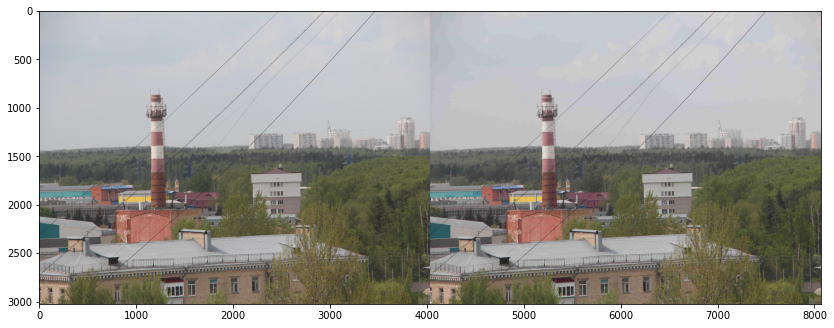

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.figure(figsize = (14,14))
plt.imshow(sample_image)
print(sample_image_fp)

In [ ]:
def split_image(image):
    image = np.array(image)
    quality, poor = image[:, :4032, :], image[:, 4032:, :]
    return quality, poor

(3024, 8064, 3)


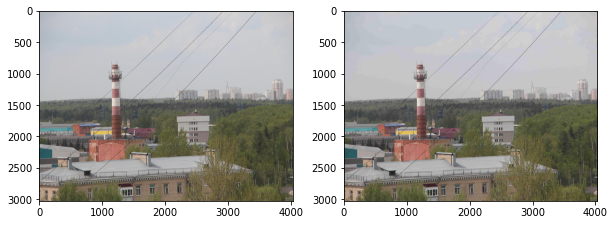

In [ ]:
sample_image = np.array(sample_image)
print(sample_image.shape)
quality, poor = split_image(sample_image)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(quality)
axes[1].imshow(poor)

## 3 Define Dataset

In [ ]:
class SkylineDataset(Dataset):
    
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        quality, poor = self.split_image(image)
        quality = self.transform(quality)
        poor = self.transform(poor)
        return quality, poor
    
    def split_image(self, image):
        image = np.array(image)
        quality, poor = image[:256, :512, :], image[:256, 4032:4544, :]
        return quality, poor

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor()
        ])
        return transform_ops(image)

In [ ]:
dataset = SkylineDataset(train_dir)
print(len(dataset))

108


In [ ]:
quality, poor = dataset[0]
print(quality.shape, poor.shape)

torch.Size([3, 256, 512]) torch.Size([3, 256, 512])


## 4 Define Model

In [ ]:
# Convolutional Layer of Conv. layers
class ConvolutionalBlock(nn.Module):
    """
    A convolutional block of the model. Contains BN and activation layer also.
    """

    def __init__(self, in_channel, out_channel, kernel_size=9):
        # Defining convolutional block.
        # Maybe I should add manual passing kernel, stride and padding parameters futher.
        super(ConvolutionalBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=1,
                          padding=kernel_size // 2),
            nn.BatchNorm2d(num_features=out_channel),
            nn.PReLU()
        )

    def forward(self, input):
        # Forward propagation.
        output = self.conv(input)  # (batch_size, out_channels, width, height)
        return output

In [ ]:
class ResidualBlock(nn.Module):
    """
    A residual block, comprising two convolutional blocks with a residual connection across them.
    """

    def __init__(self, kernel_size=3, n_channels=64):
        # Defining ResidualBlock.
        super(ResidualBlock, self).__init__()

        self.conv_1 = ConvolutionalBlock(
            in_channel=n_channels, 
            out_channel=n_channels, 
            kernel_size=kernel_size
        )

        self.conv_2 = ConvolutionalBlock(
            in_channel=n_channels, 
            out_channel=n_channels, 
            kernel_size=kernel_size
        )

    def forward(self, input):
        # Forward propagation.
        residual = input
        output = self.conv_1(input)
        output = self.conv_2(output)
        output = output + residual  # (batch_size, out_channels, width, height)

        return output

In [ ]:
class SRResNet(nn.Module):
    
    def __init__(self, kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16):
        super(SRResNet, self).__init__()
        # scaling_factor = 4

        # First convolutional block
        self.conv_1 = ConvolutionalBlock(
            in_channel=3, 
            out_channel=n_channels, 
            kernel_size=kernel_size
        )

        self.res = nn.Sequential(
            *[ResidualBlock(
                kernel_size=small_kernel_size, 
                n_channels=n_channels
            ) for i in range(n_blocks)]
        )

        # Second convolutional block
        self.conv_2 = ConvolutionalBlock(
            in_channel=n_channels, 
            out_channel=n_channels, 
            kernel_size=kernel_size
        )

        # Third convolutional block
        self.conv_3 = ConvolutionalBlock(
            in_channel=n_channels, 
            out_channel=3, 
            kernel_size=kernel_size
        )

   
    def forward(self, image):
        # Forward propagation.

        output = self.conv_1(image)
        residual = output
        output = self.res(output)
        output = self.conv_2(output)
        output = output + residual
        #output = self.subpixel_convolutional_blocks(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        output_image = self.conv_3(output)

        return output_image

In [ ]:
model = SRResNet()

In [ ]:
data_loader = DataLoader(dataset, batch_size=1)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

108 27
torch.Size([4, 3, 256, 512]) torch.Size([4, 3, 256, 512])


In [ ]:
Y_pred = model(X)
print(Y_pred.shape)

In [ ]:
Y_pred

tensor([[[[ 2.7779,  5.5982,  4.7361,  ..., -0.6281, -0.6638, -1.5412],
          [ 0.5238,  3.8491,  0.5990,  ..., -2.7203, -2.1234, -2.2370],
          [ 1.1251,  6.4776,  0.9182,  ..., -2.0525, -1.4497, -1.6720],
          ...,
          [-0.2621,  2.1035, -0.4277,  ..., -1.5769, -1.1365, -0.8632],
          [ 0.5240,  5.7222,  3.6579,  ..., -0.6122, -0.5811, -0.2562],
          [-0.0979,  4.6804,  3.8662,  ..., -0.8519, -0.0546,  0.6503]],

         [[-1.0813, -0.9235, -0.4625,  ..., -0.3545, -0.8550, -0.5433],
          [-0.2876,  0.3940, -0.0534,  ..., -0.3561, -0.8003, -0.2942],
          [ 4.7554,  6.4967,  5.3302,  ...,  6.0245,  0.7496,  0.5275],
          ...,
          [ 0.6373,  1.6113, -0.1435,  ...,  0.7046, -0.3137, -0.3240],
          [ 0.6368,  1.8369, -0.0790,  ...,  2.1803,  1.5565,  1.4638],
          [ 6.4313,  4.7583,  1.6478,  ...,  4.0365,  2.0302,  1.9866]],

         [[-0.2955, -0.4733, -0.3337,  ..., -0.6856, -0.3230,  2.2815],
          [-0.5412, -0.6420, -